In [1]:
import time
import numpy as np
import cv2
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import signal
import os, errno
import glob

## compute kinematic paramters - velocity (speed and angular velocity)

In [2]:
# load centroid file wih distance and centroid data

df = pd.read_csv('./dataFolders/Output/KinematicAnalysis_v5/CentroidAndDistanceData.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,name,visit,flower_r,flower_x,flower_y,x,y,x_pixel,y_pixel,x_smoothened,y_smoothened,cent_x,cent_y,distance,distanceincms
0,0,0,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,L0.1_c-3_m10,last,74,310,233,0.810811,2.297297,24.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,L0.1_c-3_m10,last,74,310,233,1.013514,2.770270,30.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# remove Problematic Files

listProbs = pd.read_csv(r'G:\My Drive\Mahad\Light Level Experiments\Data Output from Analysis\VideosWithMarkers\FirstLastTroubleVideos_v4\names.csv')
listProbs['name'] = listProbs['name'].str[1:]
listProbs.head()

# df.name.str.contains(df.name + '_' + df.visitNum)

,Unnamed: 0,name
0,0,L0.1_c-3_m10_firstVisit.csv
1,1,L0.1_c-3_m10_lastVisit.csv
2,2,L0.1_c-3_m12_firstVisit.csv
3,3,L0.1_c-3_m12_lastVisit.csv
4,4,L0.1_c-3_m23_lastVisit.csv


In [4]:
df['string'] = df.name + '_' + df.visit + 'Visit.csv'

sub_df= df[pd.DataFrame(df.string.tolist()).isin(listProbs.name.tolist()).any(1) == False]

In [5]:
sub_df.head()

,Unnamed: 0,Unnamed: 0.1,name,visit,flower_r,flower_x,flower_y,x,y,x_pixel,y_pixel,x_smoothened,y_smoothened,cent_x,cent_y,distance,distanceincms,string
2818,2818,2818,L0.1_c-3_m2,first,74,309,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv
2819,2819,2819,L0.1_c-3_m2,first,74,309,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv
2820,2820,2820,L0.1_c-3_m2,first,74,309,233,14.054054,16.216216,416.0,480.0,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv
2821,2821,2821,L0.1_c-3_m2,first,74,309,233,12.027027,15.777027,356.0,467.0,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv
2822,2822,2822,L0.1_c-3_m2,first,74,309,233,17.398649,15.810811,515.0,468.0,NaN,NaN,NaN,NaN,NaN,NaN,L0.1_c-3_m2_firstVisit.csv


In [6]:
df_use = sub_df.copy()
df_use[['lightLevel', 'mothID']] =  df_use['name'].str.split('_', n = 1, expand = True)
df_use = df_use.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 
                                'name',
                                'flower_x', 'flower_y',
                                'x', 'y',
#                                 'x_pixel', 'y_pixel',
                                'distance', 'distanceincms',
                                'string'
                                ])

In [7]:
df_use.head()

,visit,flower_r,x_pixel,y_pixel,x_smoothened,y_smoothened,cent_x,cent_y,lightLevel,mothID
2818,first,74,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m2
2819,first,74,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m2
2820,first,74,416.0,480.0,NaN,NaN,NaN,NaN,L0.1,c-3_m2
2821,first,74,356.0,467.0,NaN,NaN,NaN,NaN,L0.1,c-3_m2
2822,first,74,515.0,468.0,NaN,NaN,NaN,NaN,L0.1,c-3_m2


## smoothen data using a low pass filter

In [8]:
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [9]:
sf = 20 # set smoothening factor for cubic spline interpolation

In [10]:
def filterTimeseries(test, lowF):
    x_interpl = test.x_pixel.interpolate(method = 'cubic')
    y_interpl = test.y_pixel.interpolate(method = 'cubic')
    test_interpl = pd.DataFrame({'x' : x_interpl,
                                'y' : y_interpl})

    # trim the NaN edges 
    first_idx = test_interpl.first_valid_index()
    last_idx = test_interpl.last_valid_index()
    first_idx, last_idx

    test_filt = test_interpl.loc[first_idx: last_idx, :].copy()

    filt_x = butter_lowpass_filter(test_filt.x.values, lowF, 100, order = 5)
    filt_y = butter_lowpass_filter(test_filt.y.values, lowF, 100, order = 5)

    test_filt.loc[:,'x'] = filt_x
    test_filt.loc[:,'y'] = filt_y

    # add the trimmed edges back to filtered timeseries
    ll =[]
    missing_ind = first_idx - test.index[0]
    if missing_ind != 0:
        for n in np.arange(missing_ind):
            ll.append(first_idx-n)

    missing_ind = test.index[-1] - last_idx
    if missing_ind != 0:
        for n in np.arange(missing_ind):
            ll.append(last_idx+n)

    for l in ll:
        test_filt.loc[l, :] = np.nan

    # reset original values back to NaN
    w_x = np.isnan(test.x_pixel)
    w_y = np.isnan(test.y_pixel)

    test_filt.loc[w_x, 'x'] = np.nan
    test_filt.loc[w_y, 'y'] = np.nan
    return(test_filt)

In [12]:
outfig = r'./dataFolders/Output/KinematicAnalysis_v5/Figures/IndividualMoths/LowPass_filteredPosition/'

In [13]:
def figureFiltered(original, filtered, ax):
    ax = ax.ravel()

    ax[0].plot(original.x_pixel)
    ax[0].plot(filtered.x)

    ax[1].plot(original.y_pixel)
    ax[1].plot(filtered.y)

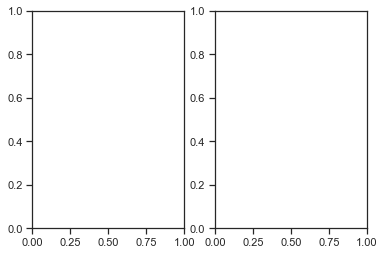

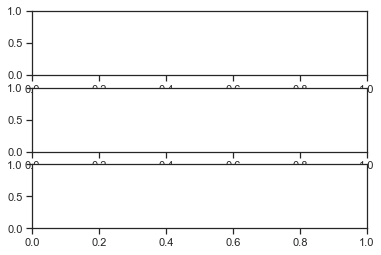

In [74]:
velocity = []
acceleration = []
light = []
visit = []
mothID = []

f0, ax0 = plt.subplots(1,2)

f1, ax1 = plt.subplots(3,1)
ax1 = ax1.ravel()

for l, light_sub in df_use.groupby('lightLevel'):
    for v, visit_sub in light_sub.groupby('visit'):
        for m, moth_sub in visit_sub.groupby('mothID'):
            lowF = 18

            filtered = filterTimeseries(moth_sub, 18)
            
            figureFiltered(moth_sub, filtered, ax0)
            f0.savefig(outfig + m + '.pdf')
            for axes in ax0:
                axes.cla()
            
            filtered.x  = filtered.x*2.5/moth_sub.flower_r.unique()
            filtered.y  = filtered.y*2.5/moth_sub.flower_r.unique()
            
            x_vel = np.gradient(filtered.x)
            x_acc = np.gradient(x_vel)
            y_vel = np.gradient(filtered.y)
            y_acc = np.gradient(y_vel)
            filtered.index = filtered.index*1/100
            
            vel = np.sqrt(x_vel**2 + y_vel**2)
            acc = np.sqrt(x_acc**2 + y_acc**2)
        
            light.extend([l]*len(vel))
            visit.extend([v]*len(vel))
            mothID.extend([m]*len(vel))
            velocity.extend(vel)
            acceleration.extend(acc)
            
            # plot shit
            ax1[0].plot(filtered.x)
            ax1[0].plot(filtered.y)
            
            ax1[1].plot(x_vel)
            ax1[1].plot(y_vel)
            ax1[1].plot(vel, alpha = 0.5)
            
            ax1[2].plot(x_acc)
            ax1[2].plot(y_acc)
            ax1[2].plot(acc, alpha = 0.5)
            
            f1.savefig('./dataFolders/Output/KinematicAnalysis_v5/Figures/velocity/v1/' + 
                    l + '_' + m + '_' + v + '_velocity.pdf')
            for axes in ax1:
                axes.cla()

In [75]:
final = pd.DataFrame({'lightLevel': light,
                     'visit': visit,
                     'mothID':mothID,
                     'velocity':velocity,
                     'acceleration': acceleration})

In [76]:
final.head()

,lightLevel,visit,mothID,velocity,acceleration
0,L0.1,first,c-3_m2,NaN,NaN
1,L0.1,first,c-3_m2,NaN,NaN
2,L0.1,first,c-3_m2,0.386017,NaN
3,L0.1,first,c-3_m2,0.553679,0.032128
4,L0.1,first,c-3_m2,0.370488,0.274609


In [78]:
mothID = []
visit = []
lightLevel = []
median_velocity = []
median_acc = []

for l, light_sub in final.groupby('lightLevel'):
    for v, visit_sub in light_sub.groupby('visit'):
        for m, moth_sub in visit_sub.groupby('mothID'):
            mean_v = np.nanmedian(moth_sub.velocity)
            mean_a = np.nanmedian(moth_sub.acceleration)
            
            median_velocity.append(mean_v)
            median_acc.append(mean_a)
            mothID.append(m)
            visit.append(v)
            lightLevel.append(l)
            
summary = pd.DataFrame({'lightLevel': lightLevel,
                       'visit': visit,
                       'mothID': mothID,
                       'median_velocity': median_velocity,
                       'median_acc': median_acc})

In [79]:
summary

,lightLevel,visit,mothID,median_velocity,median_acc
0,L0.1,first,c-3_m2,0.093502,0.044844
1,L0.1,first,c-3_m20,0.131496,0.072999
2,L0.1,first,c-3_m21,0.148915,0.107971
3,L0.1,first,c-3_m22,0.176730,0.116656
4,L0.1,first,c-3_m23,0.174876,0.092243
...,...,...,...,...,...
70,L50,last,c-3_m37,0.180078,0.093553
71,L50,last,c-3_m38,0.129263,0.076881
72,L50,last,c-3_m39,0.205198,0.109382
73,L50,last,c-3_m45,0.175117,0.127471


In [80]:
summary.to_csv(r'./dataFolders/Output/KinematicAnalysis_v5/MothCentricVelocity.csv')

In [81]:
summary.groupby('visit').mean()

,median_velocity,median_acc
visit,,
first,0.153659,0.086635
last,0.167728,0.088761


In [82]:
colorScheme = {'L0.1':plt.cm.Purples_r, 'L50':plt.cm.Oranges_r}

In [83]:
import seaborn as sns
sns.set(style="ticks")
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 8

w = 7/3
# w = 8
h = w * 2

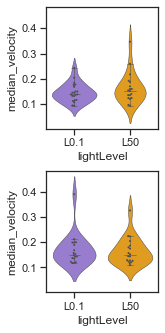

In [70]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0
for v, sub in summary.groupby('visit'):
    sns.violinplot(x='lightLevel', y='median_velocity', data = sub, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='median_velocity', data = sub, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
    sns.swarmplot(x='lightLevel', y='median_velocity', data = sub,
                size=2, 
                  color="0.3",
                  linewidth=0,
                  ax=ax[i])
    i+=1
plt.tight_layout()

f.savefig('./dataFolders/Output/KinematicAnalysis_v5/Figures/mothCentricVelocity.pdf')

In [62]:
low_first = summary[(summary.lightLevel == 'L0.1') & (summary.visit == 'first')].median_velocity.values
high_first = summary[(summary.lightLevel == 'L50') & (summary.visit == 'first')].median_velocity.values

low_last = summary[(summary.lightLevel == 'L0.1') & (summary.visit == 'last')].median_velocity.values
high_last = summary[(summary.lightLevel == 'L50') & (summary.visit == 'last')].median_velocity.values

In [63]:
from scipy import stats

stats.mannwhitneyu(low_first, high_first)

MannwhitneyuResult(statistic=154.0, pvalue=0.16554333549676253)

In [64]:
stats.mannwhitneyu(low_last, high_last)

MannwhitneyuResult(statistic=158.0, pvalue=0.455913205876692)

In [65]:
stats.ks_2samp(low_first, high_first)

Ks_2sampResult(statistic=0.2698412698412698, pvalue=0.40446949180451686)

In [66]:
stats.ks_2samp(low_last, high_last)

Ks_2sampResult(statistic=0.16666666666666666, pvalue=0.9715397823325015)

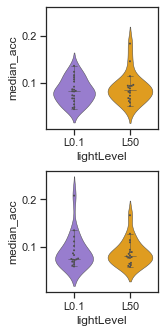

In [84]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0
for v, sub in summary.groupby('visit'):
    sns.violinplot(x='lightLevel', y='median_acc', data = sub, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='median_acc', data = sub, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
    sns.swarmplot(x='lightLevel', y='median_acc', data = sub,
                size=2, 
                  color="0.3",
                  linewidth=0,
                  ax=ax[i])
    i+=1
plt.tight_layout()

f.savefig('./dataFolders/Output/KinematicAnalysis_v5/Figures/mothCentricAcceleration.pdf')

In [87]:
low_first = summary[(summary.lightLevel == 'L0.1') & (summary.visit == 'first')].median_acc.values
high_first = summary[(summary.lightLevel == 'L50') & (summary.visit == 'first')].median_acc.values

low_last = summary[(summary.lightLevel == 'L0.1') & (summary.visit == 'last')].median_acc.values
high_last = summary[(summary.lightLevel == 'L50') & (summary.visit == 'last')].median_acc.values

print(stats.mannwhitneyu(low_first, high_first))
print(stats.mannwhitneyu(low_last, high_last))

print(stats.ks_2samp(low_first, high_first))
print(stats.ks_2samp(low_last, high_last))

MannwhitneyuResult(statistic=168.0, pvalue=0.2817934156521315)
MannwhitneyuResult(statistic=155.0, pvalue=0.4185318077449268)
Ks_2sampResult(statistic=0.16666666666666666, pvalue=0.9100418854707246)
Ks_2sampResult(statistic=0.2777777777777778, pvalue=0.5025900605581054)
